# SOLUTION NOTEBOOK

---

# MNIST multilayer network

Solution - Load and preprocess data
---

> **Exercise**: Load the MNIST data. Split it into train, validation and test sets. Standardize the images. Define a `get_batches(X, y, batch_size)` function to generate random X/y batches of size `batch_size` using a Python generator.

In [3]:
import numpy as np
import os

# Load data
with np.load(os.path.join("c4_mnist-60k.npz"), allow_pickle=False) as npz_file:
    # Load items into a dictionary
    mnist = dict(npz_file.items())

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Create train set
X_train, X_test, y_train, y_test = train_test_split(
    # Convert uint8 pixel values to float
    mnist["data"].astype(np.float32),
    mnist["labels"],
    test_size=2000,
    random_state=0,
)

# Create validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=1000, random_state=0
)

# Rescale input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (58000, 784) (58000,)
Valid: (1000, 784) (1000,)
Test: (1000, 784) (1000,)


In [5]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y))  # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i : i + batch_size]
        yield X[batch_idx], y[batch_idx]

Solution - Create and train a multilayer network
---

> **Exercise:** Create a multilayer neural network and train it using your batch generator. Evaluate the accuracy on the validation set after each epoch. Test different architectures and parameters. Evaluate your best network on the test set. Save the trained weights of the first fully connected layer in a variable.

In [6]:
import tensorflow as tf

# Define hidden layer with 64 units
hidden_layer = tf.keras.layers.Dense(
    units=64,
    activation=tf.nn.relu,  # ReLU
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=2, distribution="truncated_normal", seed=0
    ),
    bias_initializer=tf.zeros_initializer(),
    name="hidden",
)

# Define output layer
logits_layer = tf.keras.layers.Dense(
    units=10,
    activation=None,  # No activation function
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1, distribution="truncated_normal", seed=0
    ),
    bias_initializer=tf.zeros_initializer(),
    name="output",
)


# Define the optimizer
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.1
)  # increase the learning rate to 0.1

# Define functions used to train the graph
@tf.function
def compute_logits(x):
    hidden_output = hidden_layer(x)
    logits = logits_layer(hidden_output)
    return logits


@tf.function
def compute_loss(y, logits):
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    mean_ce = tf.reduce_mean(ce)
    return mean_ce


@tf.function
def compute_accuracy(y, logits):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    return acc


@tf.function
def train(x, y):
    with tf.GradientTape() as tape:
        logits = compute_logits(x)
        loss = compute_loss(y, logits)
    # Concatenate the tarainable variables in one list usint the '+' operation on lists
    variables = hidden_layer.trainable_variables + logits_layer.trainable_variables
    optimizer.minimize(loss=loss, var_list=variables, tape=tape)
    return logits, loss

In [7]:
# Validation accuracy
valid_acc_values = []

# Set seed
np.random.seed(0)

# Train several epochs
for epoch in range(15):
    # Accuracy values (train) after each batch
    batch_acc = []

    # Get batches of data
    for X_batch, y_batch in get_batches(X_train, y_train, 64):
        # Run training
        batch_logits, _ = train(X_batch, y_batch)

        # Evaluate training accuracy (on current batch)
        acc = compute_accuracy(y_batch, batch_logits)
        batch_acc.append(acc)

    # Evaluate validation accuracy (on the whole data)
    valid_logits = compute_logits(X_valid)
    valid_acc = compute_accuracy(y_valid, valid_logits)
    valid_acc_values.append(valid_acc)

    # Print progress
    print(
        "Epoch {} - valid: {:.3f} train: {:.3f} (mean)".format(
            epoch + 1, valid_acc, np.mean(batch_acc)
        )
    )

# Evaluate test accuracy after training
test_logits = compute_logits(X_test)
test_acc = compute_accuracy(y_test, test_logits)
print("Test accuracy: {:.3f}".format(test_acc))

# Extract weights of the hidden layer
W1 = hidden_layer.kernel

Epoch 1 - valid: 0.951 train: 0.916 (mean)
Epoch 2 - valid: 0.962 train: 0.957 (mean)
Epoch 3 - valid: 0.965 train: 0.968 (mean)
Epoch 4 - valid: 0.966 train: 0.975 (mean)
Epoch 5 - valid: 0.968 train: 0.980 (mean)
Epoch 6 - valid: 0.970 train: 0.985 (mean)
Epoch 7 - valid: 0.969 train: 0.987 (mean)
Epoch 8 - valid: 0.971 train: 0.990 (mean)
Epoch 9 - valid: 0.970 train: 0.992 (mean)
Epoch 10 - valid: 0.971 train: 0.993 (mean)
Epoch 11 - valid: 0.970 train: 0.995 (mean)
Epoch 12 - valid: 0.971 train: 0.996 (mean)
Epoch 13 - valid: 0.974 train: 0.997 (mean)
Epoch 14 - valid: 0.973 train: 0.998 (mean)
Epoch 15 - valid: 0.975 train: 0.998 (mean)
Test accuracy: 0.977


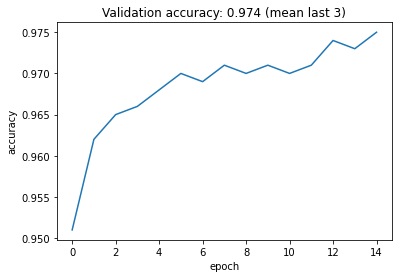

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title(
    "Validation accuracy: {:.3f} (mean last 3)".format(np.mean(valid_acc_values[-3:]))
)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

Solution - Visualize weights
---

> **Exercise**: Plot the weights from the first fully connected layer (the templates) with the `imshow()` function.

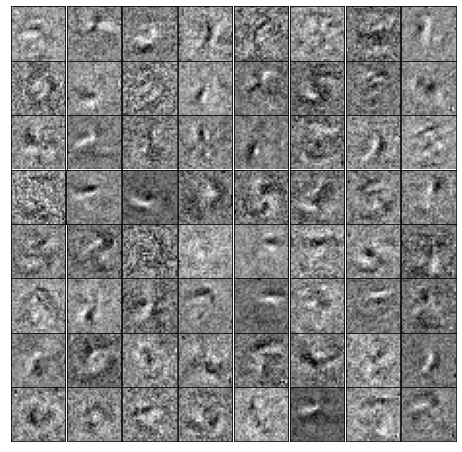

In [9]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the weights of the 64 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights = W1[:, i].numpy()

    # Reshape into 28 by 28 array
    weights = weights.reshape(28, 28)

    # Plot weights
    axis.imshow(weights, cmap=plt.cm.gray_r)  # Grayscale
    axis.get_xaxis().set_visible(False)  # Disable x-axis
    axis.get_yaxis().set_visible(False)  # Disable y-axis

plt.show()